# Getting Started with Decision Trees Using fastai

In this ocassion I want to share with you what I've learned in fast.ai's Lesson 6 and chapter 9 of the book of the same course. Turns out, I'm learning about decision trees. Thus, I think that this competition is an excelent opportunity to put in practice my knowledge. 

Let's begin by downloading the data. The following code block determines whether you're working in a Kaggle notebook or locally. If you're working locally, you'll need to use the Kaggle API. If you're unfamiliar with it, here's [a walkthrough on how to use the Kaggle API](https://karensanchez777.github.io/posts/2025-01-19-kaggle-api/learning-to-use-kaggle-api.html).

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/playground-series-s5e1')
else:
    path = Path('playground-series-s5e1')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

Import the module of fastai dedicated to tabular data. It already includes the pandas and numpy libraries, so we don't need to import them.

In [2]:
from fastai.tabular.all import *

df = pd.read_csv(path/'train.csv')
df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
df_test = pd.read_csv(path/'test.csv')

In [4]:
df_test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


First of all, identify the dependent variable, which is `num_sold`:

In [5]:
dep_var='num_sold'

The function `describe` of a Pandas DataFrame provide us a brief summary of the variables in the dataframe

In [6]:
df.describe(include=np.number)

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [7]:
df.describe(include=['object'])

,date,country,store,product
count,230130,230130,230130,230130
unique,2557,6,3,5
top,2010-01-01,Canada,Discount Stickers,Holographic Goose
freq,90,38355,76710,46026


## 1. Working with Dates in Pandas

This a time series problem, so it might be a good idea to know how to handles dates. In order to extract information about  the `date` column, like, what is the period of time that covers the training set, we can use the next techniques:  

- Convert date strings to `datetime` objects:

In [8]:
df["date"] = df["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [9]:
df_test["date"] = df_test["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

- `df.describe()` can also give us a quick glance at the values of the date column:

In [10]:
df.describe(include='datetime')

,date
count,230130
mean,2013-07-02 00:00:00
min,2010-01-01 00:00:00
25%,2011-10-02 00:00:00
50%,2013-07-02 00:00:00
75%,2015-04-02 00:00:00
max,2016-12-31 00:00:00


We note that the training set covers the data of sticker sales from January 1, 2010 to December 31, 2016.

- Extract details like years or months:

In [11]:
df["date"].dt.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int32)

In [12]:
df["date"].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

We confirm that the dataset contains the sales info from (the beggining of) 2010 to (the end of) 2016. What about the test dataset?

In [13]:
df_test["date"].dt.year.unique()

array([2017, 2018, 2019], dtype=int32)

You can also calculate time differences or derive weekday numbers using `datetime`. For example:

In [14]:
delta = datetime(2025,1,27)-datetime(2025, 1, 20)
delta.days

7

In [15]:
today=datetime.now()
print(f"You can verify that today is day number {today.weekday()} of the week and week number {today.strftime('%U')} of the year.")

You can verify that today is day number 2 of the week and week number 03 of the year.


## 2. Creating Features from Dates

Dates can provide a wealth of information when transformed into categorical or continuous variables:

- `add_datepart` is a helpful function of the fastai's tabular module because it creates new features such as day of the week, week of the year, and year-end indicators based on the `date` column. They are important to study the relationship between the sales and, for example, weekends or holidays.

In [16]:
df=add_datepart(df,"date")
df.head()

,id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09


## 3. Preparing the Dataset

To train decision trees effectively:  

- Ensure all columns are numerical, with no missing values. The next utilities of fastai address this issues in the dataset:
  - **`FillMissing`**: Fill missing values in the continuous features of the dataset using its median by default, but it doesn't take into account the missing values in the dependent variable.
  - **`Categorify`**: Convert categorical variables to numerical codes.

Let's see where do we have missing values:

In [17]:
df.isna().sum()

id                     0
country                0
store                  0
product                0
num_sold            8871
Year                   0
Month                  0
Week                   0
Day                    0
Dayofweek              0
Dayofyear              0
Is_month_end           0
Is_month_start         0
Is_quarter_end         0
Is_quarter_start       0
Is_year_end            0
Is_year_start          0
Elapsed                0
dtype: int64

We can observe that the single variable with missing values is the dependent variable. 

Decision trees can't function with missing values in the dependent variable (nor in the independent variables), then we should find out a way to treat them, such as, filling them or eliminating those values, depending on whether the size of the dataset is large enough. Here I'm going to fill them with the median of the dependent variable.

In [18]:
median=df["num_sold"].median()
df["num_sold"]=df["num_sold"].fillna(median)
df.isna().sum()

id                  0
country             0
store               0
product             0
num_sold            0
Year                0
Month               0
Week                0
Day                 0
Dayofweek           0
Dayofyear           0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
Elapsed             0
dtype: int64

As there were no missing values in the features, then we only need to categorify the categorical variables.

In [19]:
procs=[Categorify]

But, which are the categorical variables? fastai also provides us a quick method to distinguish between continuous and categorical variables: 

In [20]:
cont,cat=cont_cat_split(df,1,dep_var)

In [21]:
print(f"Continuous variables: {cont}")
print(f"Categorical variables: {cat}")

Continuous variables: ['id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed']
Categorical variables: ['country', 'store', 'product', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']


## 4. Validation set

- For time-series problems, remember: **we are trying to predict the future**.

The validation set have to represent future data. As we want the validation set to reflect the test set, we will build the validation set such that it spans the data from the last three years in the training set. 

In [22]:
cond = df["Year"]<2014
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

In [23]:
len(splits[0])

131490

## 5. TabularPandas

Create a tabular object of fastai. We need to tell to it:
* where is the data
* how to process the data
* which columns are continuous and wich columns are categorical
* which is the target variable
* and how to split the data to create training and validation sets.

In [24]:
to = TabularPandas(df, procs, cat, cont, dep_var, splits=splits)

`TabularPandas` returns `train` and `valid` attributes. 

In [25]:
train_xs, train_y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now all the variables have numerical values and we are ready train the decision tree:

In [26]:
train_xs.dtypes

country                int8
store                  int8
product                int8
Is_month_end           int8
Is_month_start         int8
Is_quarter_end         int8
Is_quarter_start       int8
Is_year_end            int8
Is_year_start          int8
id                    int32
Year                  int16
Month                  int8
Week                   int8
Day                    int8
Dayofweek              int8
Dayofyear             int16
Elapsed             float32
dtype: object

In [27]:
valid_xs.dtypes

country                int8
store                  int8
product                int8
Is_month_end           int8
Is_month_start         int8
Is_quarter_end         int8
Is_quarter_start       int8
Is_year_end            int8
Is_year_start          int8
id                    int32
Year                  int16
Month                  int8
Week                   int8
Day                    int8
Dayofweek              int8
Dayofyear             int16
Elapsed             float32
dtype: object

## 6. Training Decision Trees

In [28]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(train_xs,train_y);

In [29]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, leaves_parallel=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

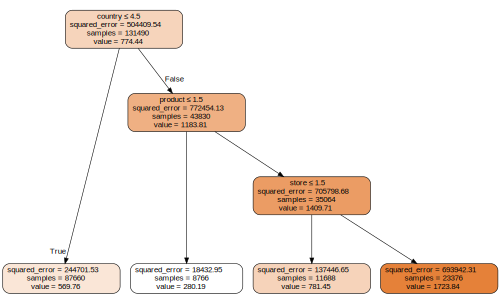

In [30]:
draw_tree(m,train_xs,size=7)

A decision tree is produced by a sequence of yes/no questions that generates binary splits. The objective of a decision tree is to locate a data point (even an unseen data point) in a group. The prediction of a decision tree is the average of the dependent variables in that group.

In the visualization of the decision tree above, we have:
* The leaf at the top of the tree is the initial model. There lives all the data points of the training set. `samples` is therefore equal to the number of samples in the training set, `value` is the average of the dependent variable in the whole training set: 

In [31]:
value = train_y.mean()
value

774.4401

`squared_error` is the average of the squared error between true y and predicted y (value).

In [32]:
squared_error=((train_y - value)**2).mean()
squared_error

504409.53

`country<=4.5`? is the first yes-no question that will create the first binary split, i.e., the first two groups. Why the decision tree algorithm decide to ask this question? The decision tree actually figure out that this was the question among all the posible yes-no questions, returns the smallest overall squared error, that is, this binary split generates the best predictions among all the possible binary splits.  

In [33]:
train_xs["country"].unique()

array([1, 2, 3, 4, 5, 6], dtype=int8)

The leaf at the bottom left is where the condition `country<=4.5` is true. We will called it "group 1". Observe that in in group 1 the sales in countries 1,2,3 and 4, the average number of sold stickers is equal to `569.76` and there are `87660` sale records. On the other hand, for the second group, group 2, conformed by sales in countries 5 and 6, the average number of sold stickers almost doubles the number of sold stickers in group 1 and its number of sale records is aproximately the half of sale records in group 1. Then, we can say that in countries 5 and 6 the ratio of number of sold stickers per sale is significantly higher.

The algorithm proceed to split group 2 according to the question `product<=1.5`?. If yes, we have group 3, where sticker 1 has an average number of sticker of 280.19 with a number of samples equals to one fifth of the data in group 2, in contrast to  `1409.71` in the group 3, but with four fifths of the data in group 2. For me. it is not obvious why product 1 has been set apart from the other products, since it has the lowest num. of  sold items of this split, but it migth be because there are fewer samples in this group: so my question is do they like or dislike sticker number 1?

And the decision goes on making questions until it has the indicated number of leaf nodes we set in the argument of our model. 

In [34]:
train_xs["product"].unique()

array([1, 2, 3, 4, 5], dtype=int8)

In [35]:
train_xs["store"].unique()

array([1, 3, 2], dtype=int8)

Some considerations when training decision trees:  

- Avoid **overfitting** by setting a maximum depth for the tree. Without limits, decision trees in scikit-learn can grow until only one observation remains per leaf, reducing their ability to generalize.

In [36]:
# Tree without limits
m = DecisionTreeRegressor()
m.fit(train_xs,train_y);

In [37]:
(m.get_n_leaves(),len(train_xs))

(116193, 131490)

There are as many leaves as data points. How well is this model performing? In order to know, we need to compute the metric: mean absolute percentage error.

## 7. Metric and Model Evaluation

The Mean Absolute Percentage Error (MAPE) is given as follows:
$$
\text{MAPE} = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1}\frac{|y_i - \hat{y}_i|}{\max(\epsilon, |y_i|)}
$$
where $y_i$ is a true value, $\hat{y}_i$ is a predicted value, $n_{samples}$ equals the number of samples, and $\epsilon$ is small number to ensure the formula works even if the true value is zero. 

MAPE measures the relative error between predicted and actual values. Smaller errors contribute less to the metric, making it effective for datasets with varying scales. Note that, if a true value is small, and the absolute error between true and predicted values is big, the relative error would be big.

The ideal value of MAPE is 0, indicating a perfect model where predicted values match the true values exactly. A MAPE value greater than 1 corresponds to an error exceeding 100% of the true value. For instance, a MAPE of 2 implies the prediction is off by 200%.


In [38]:
from sklearn.metrics import mean_absolute_percentage_error

def mape(m,xs,y):
    return mean_absolute_percentage_error(y,m.predict(xs))

In [39]:
mape(m,train_xs,train_y)

0.0

Hold on a second, please!

In [40]:
mape(m,valid_xs,valid_y)

0.44957757257369363

The model is not as good as we tought it was! The reason is that the decision tree has been overfitted since there are aproximately the same number of leaves as data points, then the decision tree is simply describing the paths (sequences of binary questions) to reach each data point in the training dataset, then it can't generalize to unseen data. 

So, we need to put a limit to the minimum number of data points in a leaf. 

In [41]:
m=DecisionTreeRegressor(min_samples_leaf=10)
m.fit(train_xs,train_y)
m.get_n_leaves(), len(train_xs)

(9916, 131490)

In [42]:
mape(m,train_xs,train_y), mape(m,valid_xs,valid_y)

(0.20584061908102447, 0.385437108848875)

Now the gap between the metric in the training set and the one in the validation set is not so large as before. 

## 8. Making a submission

Apply the same data processing to the test set as the training set:

- Create new features based on date column.
- Indicate which are the categorical and continuous features.
- `Categorify` to assign numerical codes to categorical variables.

We are going to use the decision tree with 9916 leaves: 

In [43]:
df_test = add_datepart(df_test,"date")
to_test = TabularPandas(df_test, procs, cat, cont)

In [44]:
test_xs = to_test.xs

In [45]:
predictions = m.predict(test_xs)

In [46]:
submission = pd.DataFrame({
    "id": df_test["id"],
    "num_sold": predictions
})
submission.head()

,id,num_sold
0,230130,605.000000
1,230131,889.000000
2,230132,822.800000
3,230133,458.947368
4,230134,534.388889


In [47]:
submission.to_csv("submission_decision_tree.csv",index=False)

## 9. Improving Performance

The model performs poorly in the test set (test MAPE (public score) around 3.0 or 300%), thus we have to revisit:

- How the validation set was created and ensure it reflects the test set.
- How the training set was created. Maybe we need to train with more data.
- Model architecture and size. The next is to train a random forest. 
- How to handle the missing data in the dependent variable. Remember we only fill them with its median.

## Final Thoughts

Hopefully, you've seen the usefulness of fastai's tabular module for a quick data processing and learned a little bit about decission trees and how to train them with the scikit-learn library. See you next time!

PS: An upvote 👍 to [my Kaggle notebook](https://www.kaggle.com/code/karensnchez/getting-started-with-decision-trees-using-fastai) will be awesome if you find it helpful 😃.